Time Series ML Pipeline (simplified)

	1.	Define objective

	2.	Collect data (chronologically ordered)

	3.	Clean data ✅

	•	Handle missing timestamps/values
	•	Fix duplicates
	•	Remove outliers (if appropriate)
	•	This step happens before any split

	4.	Feature engineering

	•	Lags, rolling means, time-based features (month, weekday…)

	5.	Split data chronologically

	•	Train = past, Test = future → no shuffling!

	6.	Scale/encode (fit on train only, apply on both)

	7.	Train model

	8.	Evaluate using walk-forward or time series CV

	9.	Tune + retrain

	10.	Deploy
	

## Step 1. Define Objective

You want to forecast monthly revenue based on close_value from deals marked as Won.

	•	You want to forecast future monthly revenue
	•	Based only on historical close_date and close_value
	•	Not yet incorporating agent/product/account info

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from prophet import Prophet
from prophet.plot import plot_plotly

import xgboost as xgb
from xgboost import XGBRegressor


from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

/Users/sayo/personal_projects/sales-ops-auto/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## Step 2: Data import

In [2]:
data_path = '/Users/sayo/personal_projects/sales-ops-auto/data'
pipeline_df = pd.read_csv(os.path.join(data_path, 'sales_pipeline.csv'))

## Step 3: Clean Data

In [3]:
# 1. Keep only 'Won' deals
df_cleaned = pipeline_df[pipeline_df['deal_stage'] == 'Won'].copy()

# 2. Drop rows with missing close_date or close_value
df_cleaned = df_cleaned.dropna(subset=['close_date', 'close_value'])

# 3. Convert close_date to datetime
df_cleaned['close_date'] = pd.to_datetime(df_cleaned['close_date'])

# 4. Sort by close_date
df_cleaned = df_cleaned.sort_values('close_date')

## Step 4: Feature Engineering

In [4]:
# Aggregate to Monthly Revenue

monthly_revenue_df = df_cleaned.resample('M', on='close_date')['close_value'].sum().reset_index()
monthly_revenue_df.columns = ['date', 'revenue']

# Set datetime index
monthly_revenue_df.set_index('date', inplace=True)

monthly_revenue_df.head()

,revenue
date,
2017-03-31,1134672.0
2017-04-30,721932.0
2017-05-31,1025713.0
2017-06-30,1338466.0
2017-07-31,696932.0


In [5]:
monthly_revenue_df['lag_1'] = monthly_revenue_df['revenue'].shift(1)
monthly_revenue_df['lag_2'] = monthly_revenue_df['revenue'].shift(2)
monthly_revenue_df['rolling_3'] = monthly_revenue_df['revenue'].rolling(window=3).mean()

monthly_revenue_df['month'] = monthly_revenue_df.index.month
monthly_revenue_df['sin_month'] = np.sin(2 * np.pi * monthly_revenue_df['month'] / 12)
monthly_revenue_df['cos_month'] = np.cos(2 * np.pi * monthly_revenue_df['month'] / 12)



- lag features : These give your model access to past values:
	•	lag_1: Revenue from last month
	•	lag_2: Revenue from 2 months ago

This helps the model learn patterns like “revenue tends to drop after a peak” or “what happened last month influences this month.”

- rolling means : This smooths out fluctuations and shows the trend over time:
	•	rolling_3: Average revenue over the past 3 months

- cyclinal features

Months are cyclical (January comes after December), but numbers 1–12 aren’t.
So we encode seasonality using sine/cosine:
	•	month_sin and month_cos help the model understand things like “Q4 spikes” or “summer dips”

This way, December and January are close together mathematically.

In [6]:
# STEP 4c: DROP NaNs before split
monthly_revenue_df = monthly_revenue_df.dropna()

⚠️ Note: We drop the first few rows here because lag and rolling features (lag_1, lag_2, rolling_3)
require past data to be computed. 

For example:

- 'lag_2' needs values from 2 months ago
- 'rolling_3' needs 3 full months of history

As a result, the first rows (March, April, May) will have NaNs and must be dropped.
This is expected and standard in time series forecasting workflows.

## Step 5 : Train/Test Split

In [7]:
n_months = len(monthly_revenue_df)
split_point = int(n_months * 0.8)

train_df = monthly_revenue_df.iloc[:split_point]
test_df = monthly_revenue_df.iloc[split_point:]

# Just to verify:
print("Train set:")
print(train_df.tail())
print("\nTest set:")
print(test_df.head())

Train set:
              revenue      lag_1      lag_2     rolling_3  month   
date                                                               
2017-06-30  1338466.0  1025713.0   721932.0  1.028704e+06      6  \
2017-07-31   696932.0  1338466.0  1025713.0  1.020370e+06      7   
2017-08-31  1050059.0   696932.0  1338466.0  1.028486e+06      8   
2017-09-30  1235264.0  1050059.0   696932.0  9.940850e+05      9   
2017-10-31   731980.0  1235264.0  1050059.0  1.005768e+06     10   

               sin_month     cos_month  
date                                    
2017-06-30  1.224647e-16 -1.000000e+00  
2017-07-31 -5.000000e-01 -8.660254e-01  
2017-08-31 -8.660254e-01 -5.000000e-01  
2017-09-30 -1.000000e+00 -1.836970e-16  
2017-10-31 -8.660254e-01  5.000000e-01  

Test set:
              revenue     lag_1      lag_2      rolling_3  month   
date                                                               
2017-11-30   938943.0  731980.0  1235264.0  968729.000000     11  \
2017-12-31

## Step 6: Scale/Encode 

Since your features are numerical and time series models can be sensitive to scale, we’ll use StandardScaler.

We’ll scale:
	•	lag_1
	•	lag_2
	•	rolling_3
	•	sin_month
	•	cos_month

Not revenue, since its my target

In [8]:
from sklearn.preprocessing import StandardScaler

# Define features to scale
features_to_scale = ['lag_1', 'lag_2', 'rolling_3', 'sin_month', 'cos_month']

# Initialize the scaler
scaler = StandardScaler()

# Fit only on training data
train_scaled = train_df.copy()
train_scaled[features_to_scale] = scaler.fit_transform(train_scaled[features_to_scale])

# Apply the same transformation to test data
test_scaled = test_df.copy()
test_scaled[features_to_scale] = scaler.transform(test_scaled[features_to_scale])

## Step 7: Train the model

In [9]:
# Linear Regression

# Use original (unscaled) input features and revenue
X_train = train_df[features_to_scale]
y_train = train_df['revenue']

X_test = test_df[features_to_scale]
y_test = test_df['revenue']

# Train model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict
y_pred = lr_model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Linear Regression MAE: {mae:.2f}")
print(f"Linear Regression RMSE: {rmse:.2f}")

Linear Regression MAE: 0.00
Linear Regression RMSE: 0.00


In [10]:
print(X_test)
print(y_test)

               lag_1      lag_2      rolling_3     sin_month  cos_month
date                                                                   
2017-11-30  731980.0  1235264.0  968729.000000 -5.000000e-01   0.866025
2017-12-31  938943.0   731980.0  934165.333333 -2.449294e-16   1.000000
date
2017-11-30     938943.0
2017-12-31    1131573.0
Name: revenue, dtype: float64


In [11]:
for true, pred in zip(y_test, y_pred):
    print(f"Actual: {true:.2f} | Predicted: {pred:.2f} | Error: {abs(true - pred):.2f}")

Actual: 938943.00 | Predicted: 938943.00 | Error: 0.00
Actual: 1131573.00 | Predicted: 1131573.00 | Error: 0.00


In [12]:
# ARIMA

# We'll use only the original revenue series, no manual lags
# Combine train + test for full index and easier forecast comparison
full_series = pd.concat([train_df['revenue'], test_df['revenue']])

# Fit ARIMA on training portion
arima_model = ARIMA(train_df['revenue'], order=(1,1,1))  # (p,d,q): tweak later if needed
arima_result = arima_model.fit()

# Forecast the number of steps in test set
forecast = arima_result.forecast(steps=len(test_df))

# Evaluate
mae = mean_absolute_error(test_df['revenue'], forecast)
rmse = np.sqrt(mean_squared_error(test_df['revenue'], forecast))

print(f"ARIMA MAE: {mae:.2f}")
print(f"ARIMA RMSE: {rmse:.2f}")

ARIMA MAE: 303279.72
ARIMA RMSE: 318206.17


/Users/sayo/personal_projects/sales-ops-auto/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/sayo/personal_projects/sales-ops-auto/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/sayo/personal_projects/sales-ops-auto/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/sayo/personal_projects/sales-ops-auto/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressiv

17:25:27 - cmdstanpy - INFO - Chain [1] start processing
17:25:27 - cmdstanpy - INFO - Chain [1] done processing


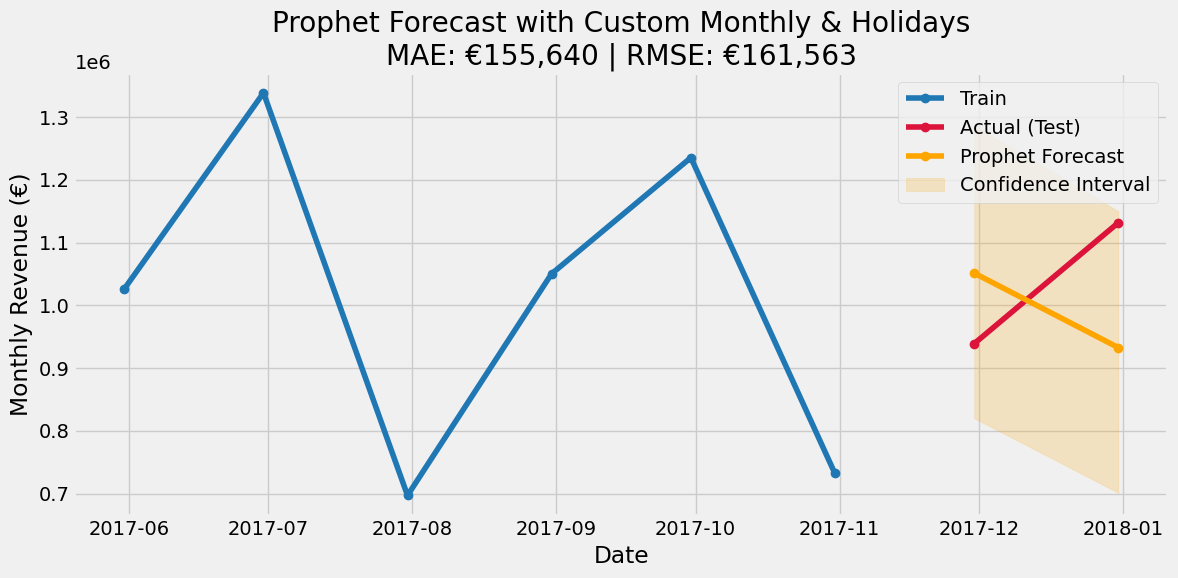

In [16]:
# --- Monthly seasonality ---
# This reinforces regular monthly patterns even with limited data
monthly_seasonality = {
    'name': 'monthly',
    'period': 30.5,
    'fourier_order': 5,
}

# --- December Holidays ---
custom_holidays = pd.DataFrame({
    'holiday': ['xmas_push'],
    'ds': pd.to_datetime(['2017-12-20']),
    'lower_window': 0,
    'upper_window': 5  # You can tweak this if needed
})

# --- Prophet Model with Additions ---
model = Prophet(
    seasonality_mode='multiplicative',
    holidays=custom_holidays
)

# Add monthly seasonality manually
model.add_seasonality(
    name=monthly_seasonality['name'],
    period=monthly_seasonality['period'],
    fourier_order=monthly_seasonality['fourier_order']
)

# Prepare data
prophet_df = train_df.reset_index()[['revenue']]
prophet_df['ds'] = train_df.index
prophet_df['y'] = prophet_df['revenue']
prophet_df = prophet_df[['ds', 'y']]

# Fit model
model.fit(prophet_df)

# Forecast
future = model.make_future_dataframe(periods=len(test_df), freq='M')
forecast = model.predict(future)
forecast_test = forecast.set_index('ds').loc[test_df.index]

# Evaluate
mae = mean_absolute_error(test_df['revenue'], forecast_test['yhat'])
rmse = np.sqrt(mean_squared_error(test_df['revenue'], forecast_test['yhat']))

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train_df.index, train_df['revenue'], label='Train', marker='o', color='#1f77b4')
plt.plot(test_df.index, test_df['revenue'], label='Actual (Test)', marker='o', color='crimson')
plt.plot(forecast_test.index, forecast_test['yhat'], label='Prophet Forecast', marker='o', color='orange')
plt.fill_between(forecast_test.index, 
                 forecast_test['yhat_lower'], 
                 forecast_test['yhat_upper'],
                 color='orange', alpha=0.2, label='Confidence Interval')

plt.title(f"Prophet Forecast with Custom Monthly & Holidays\nMAE: €{mae:,.0f} | RMSE: €{rmse:,.0f}")
plt.xlabel("Date")
plt.ylabel("Monthly Revenue (€)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
# Forecast 3 months into the future
future = model.make_future_dataframe(periods=3, freq='M')
forecast = model.predict(future)

# Slice the forecast to show only the new predictions
future_forecast = forecast[forecast['ds'] > test_df.index.max()][['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
print(future_forecast)

          ds          yhat     yhat_lower    yhat_upper
8 2018-01-31  1.090962e+06  861251.471498  1.302911e+06


/var/folders/78/fvr_pjz530z18q7trgx97kf00000gn/T/ipykernel_83869/3198932897.py:24: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from current font.
  plt.tight_layout()
/Users/sayo/personal_projects/sales-ops-auto/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


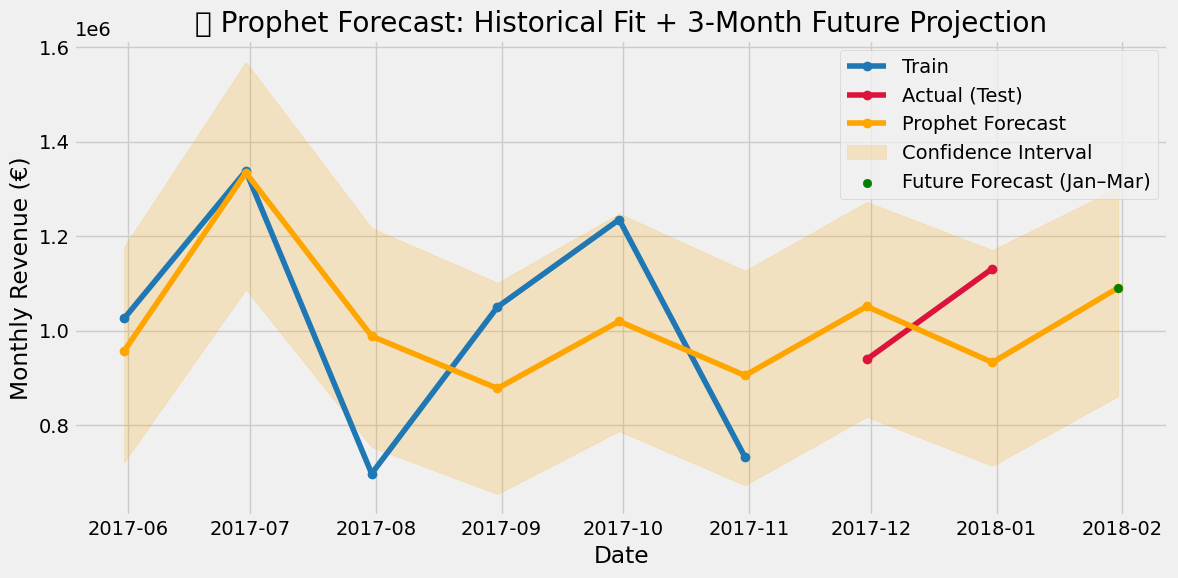

In [18]:
# 📊 Plot full history + future forecast
plt.figure(figsize=(12, 6))

# Past data
plt.plot(train_df.index, train_df['revenue'], label='Train', marker='o', color='#1f77b4')
plt.plot(test_df.index, test_df['revenue'], label='Actual (Test)', marker='o', color='crimson')

# Forecast including future
plt.plot(forecast.set_index('ds').index, forecast['yhat'], label='Prophet Forecast', marker='o', color='orange')
plt.fill_between(forecast.set_index('ds').index, 
                 forecast['yhat_lower'], 
                 forecast['yhat_upper'],
                 color='orange', alpha=0.2, label='Confidence Interval')

# Highlight the 3 forecasted future points
plt.scatter(future_forecast['ds'], future_forecast['yhat'], color='green', label='Future Forecast (Jan–Mar)', zorder=5)

# Labels
plt.title("🔮 Prophet Forecast: Historical Fit + 3-Month Future Projection")
plt.xlabel("Date")
plt.ylabel("Monthly Revenue (€)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
# Forecast enough months ahead to include Jan–Mar 2018
future = model.make_future_dataframe(periods=5, freq='M')
forecast = model.predict(future)

# Extract only Jan–Mar 2018 (future beyond full dataset, not just test set)
last_date = monthly_revenue_df.index.max()  # This includes test
future_forecast = forecast[forecast['ds'] > last_date].copy()

# Print results
for _, row in future_forecast.iterrows():
    month = row['ds'].strftime('%B %Y')
    yhat = round(row['yhat'])
    lower = round(row['yhat_lower'])
    upper = round(row['yhat_upper'])
    print(f"{month:<15} | Predicted: €{yhat:,} | Range: €{lower:,} – €{upper:,}")

January 2018    | Predicted: €1,090,962 | Range: €867,416 – €1,327,845
February 2018   | Predicted: €2,740,100 | Range: €2,505,431 – €2,976,123
March 2018      | Predicted: €2,131,035 | Range: €1,895,547 – €2,355,189
